In [1]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model

import numpy as np

Using TensorFlow backend.
/Users/mbp2016/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
img_shape = (28, 28, 1)
batch_size = 16

latent_dim = 100

In [3]:
# encoder
input_img = keras.Input(shape=img_shape)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [4]:
def sampling(args):
    z_mean, z_log_var = args

    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon


z = layers.Lambda(sampling)([z_mean, z_log_var])

In [5]:
# decoder
decoder_input = keras.Input(shape=K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)
decoder = Model(decoder_input, x)
encoder = Model(input_img, z)
z_decoded = decoder(z)

https://rdipietro.github.io/friendly-intro-to-cross-entropy-loss/
The KL divergence from  y^  to  y  is simply the difference between cross entropy and entropy:

In [6]:
def vae_loss(x, z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)
    xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
    kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

    return K.mean(xent_loss + kl_loss)

In [7]:
vae = Model(input_img, z_decoded)

In [8]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [9]:
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [10]:
from keras.datasets import mnist
from keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.reshape(x_test.shape + (1,))

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

In [11]:
vae.fit(x_train, x_train, shuffle=True, epochs=10, batch_size=batch_size, validation_data=(x_test, x_test), verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 360s 6ms/step - loss: 0.1169 - val_loss: 0.0973
Epoch 2/10
60000/60000 [==============================] - 356s 6ms/step - loss: 0.0915 - val_loss: 0.0878
Epoch 3/10
60000/60000 [==============================] - 322s 5ms/step - loss: 0.0872 - val_loss: 0.0850
Epoch 4/10
60000/60000 [==============================] - 324s 5ms/step - loss: 0.0852 - val_loss: 0.0846
Epoch 5/10
60000/60000 [==============================] - 320s 5ms/step - loss: 0.0841 - val_loss: 0.0831
Epoch 6/10
60000/60000 [==============================] - 321s 5ms/step - loss: 0.0832 - val_loss: 0.0833
Epoch 7/10
60000/60000 [==============================] - 323s 5ms/step - loss: 0.0826 - val_loss: 0.0822
Epoch 8/10
60000/60000 [==============================] - 325s 5ms/step - loss: 0.0822 - val_loss: 0.0823
Epoch 9/10
60000/60000 [==============================] - 326s 5ms/step - loss: 0.0818 - val_loss: 0.0

In [109]:
six = y_train_cat[y_train == 6][0]
six_image = x_train[y_train == 6][0]

eight = y_train_cat[y_train == 9][1]
eight_image = x_train[y_train == 9][1]

In [110]:
import matplotlib.pyplot as plt
plt.imshow(six_image[:, :, 0])
plt.show()

In [111]:
plt.imshow(eight_image[:, :, 0])
plt.show()

In [112]:
six_latent = encoder.predict(six_image.reshape([1, 28, 28, 1]))
six_decoded = decoder.predict(six_latent)

In [113]:
six_decoded = six_decoded.reshape([28, 28, 1])
plt.imshow(six_decoded[:, :, 0])
plt.show()

In [114]:
eight_latent = encoder.predict(eight_image.reshape([1, 28, 28, 1]))
eight_decoded = decoder.predict(eight_latent)


In [115]:
eight_decoded = eight_decoded.reshape([28, 28, 1])
plt.imshow(eight_decoded[:, :, 0])
plt.show()


In [116]:
eight_minus_six_latent = 0.1*six_latent + eight_latent

eight_minus_six_decoded = decoder.predict(eight_minus_six_latent)
eight_minus_six_decoded = eight_minus_six_decoded.reshape([28, 28, 1])
plt.imshow(eight_minus_six_decoded[:, :, 0])
plt.show()


<IPython.core.display.Javascript object>


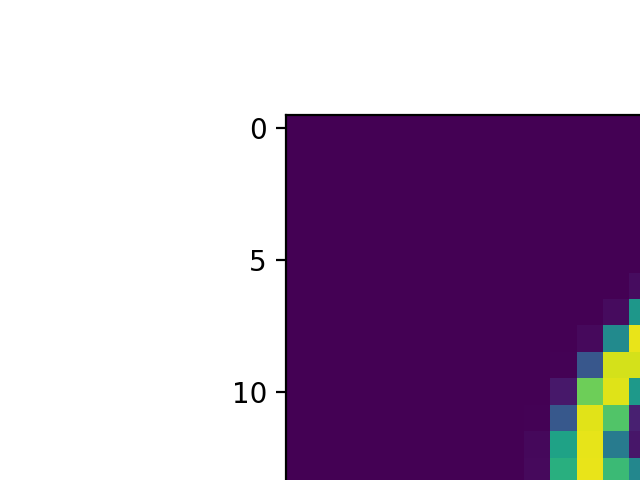

0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.69
0.7
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.82
0.83
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99


In [117]:
%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()


def f(x, y):
    return np.sin(x) + np.cos(y)

def g(x):
    eight_minus_six_latent = (1-x)*six_latent + x*eight_latent
    eight_minus_six_decoded = decoder.predict(eight_minus_six_latent)
    eight_minus_six_decoded = eight_minus_six_decoded.reshape([28, 28, 1])
    return eight_minus_six_decoded[:, :, 0]

# x = np.linspace(0, 1, 120)
# y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(100):
#     x += np.pi / 15.
#     y += np.pi / 20.
    x = i/100
    im = plt.imshow(g(x), animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

# ani.save('dynamic_images.mp4')

plt.show()

In [118]:
ani.save('animation.gif', writer='imagemagick', fps=60)